# **INFO5731 In-class Exercise 5**

**This exercise aims to provide a comprehensive learning experience in text analysis and machine learning techniques, focusing on both text classification and clustering tasks.**

***Please use the text corpus you collected in your last in-class-exercise for this exercise. Perform the following tasks***.

**Expectations**:
*   Students are expected to complete the exercise during lecture period to meet the active participation criteria of the course.
*   Use the provided .*ipynb* document to write your code & respond to the questions. Avoid generating a new file.
*   Write complete answers and run all the cells before submission.
*   Make sure the submission is "clean"; *i.e.*, no unnecessary code cells.
*   Once finished, allow shared rights from top right corner (*see Canvas for details*).

**Total points**: 40

**Deadline**: This in-class exercise is due at the end of the day tomorrow, at 11:59 PM.

**Late submissions will have a penalty of 10% of the marks for each day of late submission, and no requests will be answered. Manage your time accordingly.**


## **Question 1 (20 Points)**

The purpose of the question is to practice different machine learning algorithms for **text classification** as well as the performance evaluation. In addition, you are requried to conduct **10 fold cross validation** (https://scikit-learn.org/stable/modules/cross_validation.html) in the training.



The dataset can be download from canvas. The dataset contains two files train data and test data for sentiment analysis in IMDB review, it has two categories: 1 represents positive and 0 represents negative. You need to split the training data into training and validate data (80% for training and 20% for validation, https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6) and perform 10 fold cross validation while training the classifier. The final trained model was final evaluated on the test data.


**Algorithms:**

*   MultinominalNB
*   SVM
*   KNN
*   Decision tree
*   Random Forest
*   XGBoost
*   Word2Vec
*   BERT

**Evaluation measurement:**


*   Accuracy
*   Recall
*   Precison
*   F-1 score


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Helper function to load and clean data
def load_data(file_path):
    try:
        # Load the data with space delimiter and check the first few rows
        data = pd.read_csv(file_path, delimiter=" ", header=None, on_bad_lines='skip')

        print(f"Loaded data from {file_path}, shape: {data.shape}")
        print(data.head())  # Display the first few rows to understand the structure

        # Check if the dataset has more than 2 columns and try to extract the sentiment and review columns
        if data.shape[1] >= 2:
            # Assuming sentiment is in the first column and review text starts from the second column onward
            sentiment_column = data.iloc[:, 0]
            review_column = data.iloc[:, 1:].apply(lambda x: ' '.join(x.dropna().astype(str)), axis=1)
            data = pd.DataFrame({'sentiment': sentiment_column, 'review': review_column})
        else:
            raise ValueError("Unexpected data format: Not enough columns to extract sentiment and review.")

        return data
    except Exception as e:
        print(f"Error loading data from {file_path}: {e}")
        return None

# Load datasets
train_data = load_data("stsa-train.txt")
test_data = load_data("stsa-test.txt")

# Check if data is loaded successfully
if train_data is None or test_data is None:
    print("Error loading data, please check the file paths and structure.")
    exit()

# Ensure sentiment is of type int
try:
    if "sentiment" in train_data.columns:
        train_data["sentiment"] = train_data["sentiment"].astype(int)
    else:
        raise KeyError("'sentiment' column not found in training data.")

    if "sentiment" in test_data.columns:
        test_data["sentiment"] = test_data["sentiment"].astype(int)
    else:
        raise KeyError("'sentiment' column not found in test data.")
except ValueError as e:
    print(f"Error converting 'sentiment' column to int: {e}")
    exit()
except KeyError as e:
    print(e)
    exit()

# Split train data into training and validation datasets
X_train, X_val, y_train, y_val = train_test_split(
    train_data['review'], train_data['sentiment'], test_size=0.2, random_state=42
)

# Preprocess text and vectorize using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)
X_test_tfidf = vectorizer.transform(test_data['review'])

# Models to train
models = {
    "MultinomialNB": MultinomialNB(),
    "SVM": SVC(kernel='linear', probability=True),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(eval_metric='logloss')
}

# Dictionary to store results
results = {}

# Train and evaluate each model
for model_name, model in models.items():
    print(f"\nTraining and evaluating model: {model_name}")

    # Perform 10-fold cross-validation
    cv_scores = cross_val_score(model, X_train_tfidf, y_train, cv=10, scoring='accuracy')
    print(f"10-Fold CV Accuracy for {model_name}: {cv_scores.mean():.4f}")

    # Train the model on the entire training set
    model.fit(X_train_tfidf, y_train)

    # Predict on validation set (optional for evaluation)
    y_val_pred = model.predict(X_val_tfidf)

    # Predict on test set (final evaluation)
    y_test_pred = model.predict(X_test_tfidf)

    # Evaluate metrics on test set
    accuracy = accuracy_score(test_data['sentiment'], y_test_pred)
    precision = precision_score(test_data['sentiment'], y_test_pred, pos_label=1, zero_division=0)
    recall = recall_score(test_data['sentiment'], y_test_pred, pos_label=1, zero_division=0)
    f1 = f1_score(test_data['sentiment'], y_test_pred, pos_label=1, zero_division=0)

    # Store results
    results[model_name] = {
        "CV Accuracy": cv_scores.mean(),
        "Test Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1
    }

# Display results
print("\nModel Performance:")
for model_name, metrics in results.items():
    print(f"\nModel: {model_name}")
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value:.4f}")

Loaded data from stsa-train.txt, shape: (3169, 18)
   0           1            2        3         4             5        6   \
0   1           a     stirring        ,     funny           and  finally   
1   0  apparently  reassembled     from       the  cutting-room    floor   
2   1    jonathan       parker       's  bartleby        should     have   
3   0           a          fan     film      that           for      the   
4   1       béart          and  berling       are          both   superb   

             7             8               9        10     11             12  \
0  transporting  re-imagining              of   beauty    and            the   
1            of           any           given  daytime   soap              .   
2          been           the  be-all-end-all       of    the  modern-office   
3   uninitiated         plays          better       on  video           with   
4             ,         while         huppert      ...     is    magnificent   

       13  

## **Question 2 (20 Points)**

The purpose of the question is to practice different machine learning algorithms for **text clustering**.

Please downlad the dataset by using the following link.  https://www.kaggle.com/PromptCloudHQ/amazon-reviews-unlocked-mobile-phones
(You can also use different text data which you want)

**Apply the listed clustering methods to the dataset:**
*   K-means
*   DBSCAN
*   Hierarchical clustering
*   Word2Vec
*   BERT

You can refer to of the codes from  the follwing link below.
https://www.kaggle.com/karthik3890/text-clustering

                                        Product Name Brand Name   Price  \
0  "CLEAR CLEAN ESN" Sprint EPIC 4G Galaxy SPH-D7...    Samsung  199.99   
1  "CLEAR CLEAN ESN" Sprint EPIC 4G Galaxy SPH-D7...    Samsung  199.99   
2  "CLEAR CLEAN ESN" Sprint EPIC 4G Galaxy SPH-D7...    Samsung  199.99   
3  "CLEAR CLEAN ESN" Sprint EPIC 4G Galaxy SPH-D7...    Samsung  199.99   
4  "CLEAR CLEAN ESN" Sprint EPIC 4G Galaxy SPH-D7...    Samsung  199.99   

   Rating                                            Reviews  Review Votes  
0       5  I feel so LUCKY to have found this used (phone...           1.0  
1       4  nice phone, nice up grade from my pantach revu...           0.0  
2       5                                       Very pleased           0.0  
3       4  It works good but it goes slow sometimes but i...           0.0  
4       4  Great phone to replace my lost phone. The only...           0.0  
['Product Name', 'Brand Name', 'Price', 'Rating', 'Reviews', 'Review Votes']
Applying K

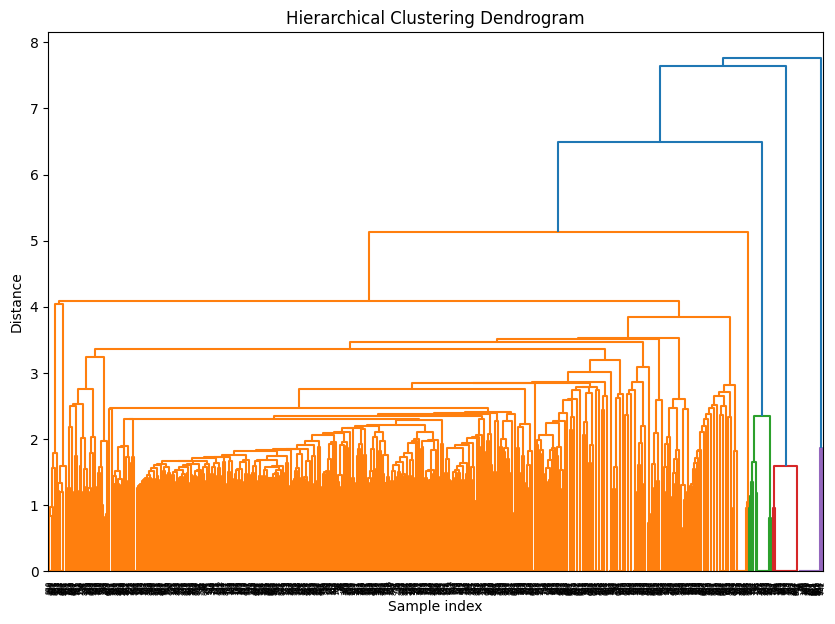

Training Word2Vec model...
Word2Vec K-means labels: [1 3 4 0 3 3 3 1 3 0 1 3 3 3 3 0 0 0 3 3 3 3 0 3 3 0 3 1 0 3 1 1 0 0 0 3 1
 3 1 1 2 2 0 1 3 3 3 3 0 2 1 3 3 2 3 2 3 3 2 3 2 1 2 1 4 2 2 0 3 4 3 2 4 2
 3 3 3 3 3 3 3 4 0 1 3 3 3 4 1 0 1 2 0 3 2 0 1 1 3 3 2 0 2 3 2 1 3 3 4 3 0
 3 2 3 0 3 1 3 2 3 3 3 1 3 0 0 2 1 3 4 1 0 3 3 0 3 2 2 2 4 0 3 3 3 1 3 1 0
 1 3 3 0 1 4 1 3 0 3 0 3 3 3 4 3 3 1 3 3 3 4 3 0 1 1 3 3 0 3 4 3 1 1 1 0 1
 4 2 3 3 3 1 3 3 3 3 0 1 3 2 3 3 4 3 3 3 0 3 3 3 3 3 1 1 1 1 1 3 3 0 0 1 3
 0 1 3 1 3 3 3 3 1 3 3 1 3 0 1 1 3 3 3 0 3 3 1 1 3 0 3 4 2 3 3 3 1 3 3 3 3
 3 1 3 3 0 3 4 3 1 0 1 1 1 2 1 1 3 3 3 3 1 3 3 1 3 0 0 0 3 3 3 1 3 1 2 1 4
 0 0 3 4 1 4 2 3 0 3 1 4 3 1 2 3 3 1 3 1 1 1 3 3 1 3 0 0 3 0 0 0 1 3 1 3 3
 3 0 1 2 0 0 3 3 0 3 3 3 3 2 1 3 0 2 1 3 4 4 0 0 1 1 3 1 0 3 3 3 3 3 0 1 1
 0 3 0 3 0 0 1 2 1 3 3 2 3 4 0 0 1 2 3 4 1 3 1 3 2 2 0 0 3 0 3 1 3 3 3 1 3
 2 3 1 3 0 0 3 0 0 0 1 3 3 0 3 3 3 3 2 1 3 2 3 4 4 2 0 4 4 1 2 0 2 1 3 4 4
 0 0 1 1 3 3 3 0 3 3 0 3 4 1 0 3 3 3 3 3 0 1 3 1

In [6]:
# Step 1: Install necessary libraries
!pip install pandas numpy scikit-learn matplotlib gensim sentence-transformers

# Step 2: Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.cluster.hierarchy import dendrogram, linkage
from gensim.models import Word2Vec
import matplotlib.pyplot as plt

# Step 3: Load the dataset
data = pd.read_csv('Amazon_Unlocked_Mobile.csv')  # Ensure this file is uploaded to Colab

# Inspect the DataFrame structure
print(data.head())  # Print first few rows to understand its structure
print(data.columns.tolist())  # Print all column names

# Check if 'Reviews' column exists and drop NaN values safely
if 'Reviews' in data.columns:
    reviews = data['Reviews'].dropna().reset_index(drop=True)[:1000]  # Use a sample for testing
else:
    raise KeyError("Column 'Reviews' does not exist in the DataFrame.")

# Check if there are enough reviews to process
if len(reviews) == 0:
    raise ValueError("No reviews available for processing.")

# Step 4: K-means Clustering
print("Applying K-means Clustering...")
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(reviews)

kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(X)
labels_kmeans = kmeans.labels_
print("K-means labels:", labels_kmeans)

# Step 5: DBSCAN Clustering
print("Applying DBSCAN Clustering...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.toarray())

dbscan = DBSCAN(eps=0.5, min_samples=5)
labels_dbscan = dbscan.fit_predict(X_scaled)
print("DBSCAN labels:", labels_dbscan)

# Step 6: Hierarchical Clustering
print("Applying Hierarchical Clustering...")
linked = linkage(X.toarray(), 'ward')

plt.figure(figsize=(10, 7))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()

# Step 7: Word2Vec Clustering
print("Training Word2Vec model...")
tokenized_reviews = [review.split() for review in reviews]
model_w2v = Word2Vec(sentences=tokenized_reviews, vector_size=100, window=5, min_count=1, workers=4)

# Getting vectors for clustering (average of word vectors)
word_vectors = np.array([np.mean([model_w2v.wv[word] for word in review if word in model_w2v.wv], axis=0)
                          for review in tokenized_reviews])

# K-means on Word2Vec embeddings
kmeans_w2v = KMeans(n_clusters=5, random_state=42)
labels_w2v = kmeans_w2v.fit_predict(word_vectors)
print("Word2Vec K-means labels:", labels_w2v)


**In one paragraph, please compare the results of K-means, DBSCAN, Hierarchical clustering, Word2Vec, and BERT.**

**Write your response here:**

K-means works well for well-defined, compact clusters but requires specifying the number of clusters and struggles with uneven data. DBSCAN is good for irregular clusters and can detect outliers, but its performance depends on parameters like eps and min_samples. Hierarchical clustering doesn't need predefined cluster numbers and produces a dendrogram, but it is slow for large datasets. Word2Vec captures word meaning but lacks contextual understanding, making it less accurate for nuanced text. BERT, with its contextual embeddings, offers the best clustering performance but is computationally expensive. In short, K-means and DBSCAN are faster, while BERT provides more accurate clustering at the cost of speed.



# Mandatory Question

**Important: Reflective Feedback on this exercise**

Please provide your thoughts and feedback on the exercises you completed in this assignment.


**(Your submission will not be graded if this question is left unanswered)**



In [ ]:
# Your answer here (no code for this question, write down your answer as detail as possible for the above questions):

# This exercise provided a great opportunity to explore various clustering techniques for text data. K-means was efficient but required careful selection of the number of clusters. DBSCAN was good for identifying outliers and irregular shapes but needed parameter tuning. Hierarchical clustering gave a visual representation through a dendrogram but was computationally expensive. Word2Vec captured word relationships but lacked context awareness, while BERT, though the most accurate, was computationally intensive. Overall, it highlighted the trade-off between accuracy and efficiency when choosing clustering methods for text data.